<a href="https://colab.research.google.com/github/dniggl/Insights/blob/main/Extract_Data_From_PDF_Files.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install the Packages**

To start we will need to install pdfquery and pandas packages. 

In [ ]:
!pip install pdfquery
!pip install pandas

**Import the Libraries**

In [ ]:
import pdfquery
import pandas as pd

*   PDFQuery is a light wrapper around pdfminer, lxml and pyquery. It is designed to read and extract data from multiple PDF files with as little code as possible. PDFQuery works by loading a PDF as a pdfminer layout, converting the layout to an etree with lxml.etree, and then applying a pyquery wrapper. All three underlying libraries are exposed, so you can use any of their interfaces to get at the data you want.
*   Pandas is an open-source library that provides high-performance data analysis and manipulation.

**Upload the PDF Files**

We are using Google colab environment so we need to load the PDF files from the local drive to the colab drive. For this project we will upload three PDF files.  

In [ ]:
# Upload pdf files from the local drive.
from google.colab import files

uploaded = files.upload()

Saving patient1pdf.pdf to patient1pdf.pdf
Saving patient2pdf.pdf to patient2pdf.pdf
Saving patient3pdf.pdf to patient3pdf.pdf


Shown below is an image of one of the PDF files. 

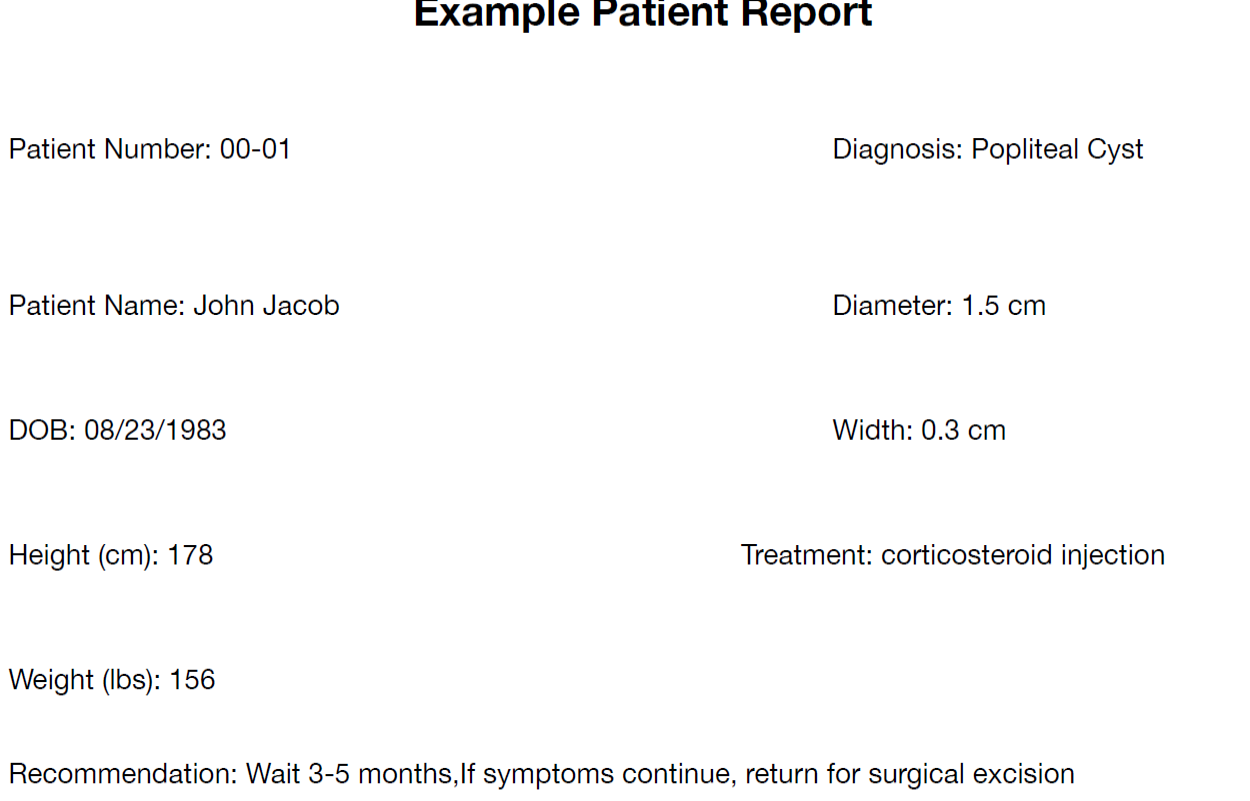

**Read and Convert the PDF Files**

We will now read one of the pdf files as an element object and load it.

In [ ]:
pdf = pdfquery.PDFQuery('patient1pdf.pdf')
pdf.load()

Next we need to convert the pdf object into an Extensible Markup Language (XML) file. This file will include data and metadata for a given pdf page.

In [ ]:
pdf.tree.write('patient1xml.xml', pretty_print = True)
pdf

XML defines a set of rules for encoding PDF in a format that is readible by humans and machines. We need to look at the XML file with a text editor to get the layout for the data we want to extract. I prefer using Sublime Text editor to look at the XML file, however you can use any text editor. 

The following is a fragment of the XML for Patient Name. It includes both data (John Jacob) and metadata (e.g., text box coordination, height, width, etc.)

In [ ]:
<LTTextLineHorizontal y0="543.657" y1="554.657" x0="72.0" x1="205.474" width="133.474"
height="11.0" bbox="[72.0, 543.657, 205.474, 554.657]" word_margin="0.1"><LTTextBoxHorizontal
y0="543.657" y1="554.657" x0="72.0" x1="205.474" width="133.474" height="11.0" bbox=
"[72.0, 543.657, 205.474, 554.657]" index="3">Patient Name: John Jacob </LTTextBoxHorizontal></LTTextLineHorizontal>

We can see the information we are looking for inside the ‘LTTextBoxHorizontal’ tag, and we can see the metadata associated with it. One way we can access this data is by using its bounding box, or ‘in_bbox’. The values inside the text box, [72.0, 543.657, 205.474, 554,657] in the XML fragment refers to “Left, Bottom, Right, Top” coordinates of the text box. You can think of this as the boundaries around the data we want to extract (patient name in this case).  

**Access and Extract Data**

In [ ]:
patient_name = pdf.pq('LTTextLineHorizontal:in_bbox("72.0, 543.657, 205.474, 554.657")').text()
patient_name

'Patient Name: John Jacob'

Sometimes the the data we want is not in the exact same location in every file which can cause issues. . Fortunately, PDFQuery can also query tags that contain a given string. Let’s get the patients name by using this method. We will first clean the text data up using the text.split method. The split() method breaks up a string at the specified separator (:) and returns a list of strings (John Jacob).  


In [ ]:
def clean_text_data(text):
 return text.split(':')[1]

patient_name = clean_text_data(pdf.pq('LTTextLineHorizontal:contains("Patient Name")').text())
patient_name

' John Jacob'

Putting it all together...

We will now use the methods described above to create a pandas dataframe from multiple PDF files. For this project we will only use 3 files but you could process thousands of files if needed.  We will write a script that reads some PDF files, loads the files, and extracts and captures the data elements. We will then create a new  dataframe.   

In [ ]:
import pdfquery
import pandas as pd

pdf_files = ['patient1pdf.pdf','patient2pdf.pdf','patient3pdf.pdf']

def clean_text_data(text):
  return text.split(':')[1]


def pdf_to_df(pdf_files):

        patient_data = {"Patient Number": [],
                       "Patient Name": [],
                       "DOB": [],
                       "Diagnosis": [],
                       "Treatment": [],
                       "Recommendation": []}

        for i in pdf_files: 
                pdf = pdfquery.PDFQuery(i)
                pdf.load()

                patient_data["Patient Number"].append(clean_text_data(pdf.pq('LTText\LineHorizontal:contains("Patient Number")').text()))

                patient_data["Patient Name"].append(clean_text_data(pdf.pq('LTText\LineHorizontal:contains("Patient Name")').text()))

                patient_data["DOB"].append(clean_text_data(pdf.pq('LTText\LineHorizontal:contains("DOB")').text()))

                patient_data["Diagnosis"].append(clean_text_data(pdf.pq('LTText\LineHorizontal:contains("Diagnosis")').text()))

                patient_data["Treatment"].append(clean_text_data(pdf.pq('LTText\LineHorizontal:contains("Treatment")').text()))
				                                         
                patient_data["Recommendation"].append(clean_text_data(pdf.pq('LTText\LineHorizontal:contains("Recommendation")').text()))


        columns=["Patient Number","Patient Name","DOB","Diagnosis","Treatment","Recommendation"]

        pdata = pd.DataFrame.from_dict(patient_data)
        pdata = pdata[columns]
        
        return pdata 	 

pdata = pdf_to_df(pdf_files)


**View the Dataframe**

Let's look at the new dataframe containing the data elements from the PDF files.

In [ ]:
pdata

,Patient Number,Patient Name,DOB,Diagnosis,Treatment,Recommendation
0,00-01,John Jacob,08/23/1983,Popliteal Cyst,corticosteroid injection,"Wait 3-5 months,If symptoms continue, return ..."
1,00-02,William Wilfred,03/11/1987,Rosacea,isotretinoin,Follow treatment as advised and avoid foods t...
2,00-03,Vince Shields,09/20/1993,Acne Cyst,Corticosteroid Injection,wait 3-5 months and follow up with dermatologist
